# Project 6: Bank Churn Prediction

**Context:** Businesses like banks that provide service have to worry about the problem of 'Churn' i.e. customers leaving and joining another service provider. It is important to understand which aspects of the service influence a customer's decision in this regard. Management can concentrate efforts on the improvement of service, keeping in mind these priorities.

**Objective**: Given a Bank customer, build a neural network-based classifier that can determine whether they will leave or not in the next 6 months.

**Data Description:** The case study is from an open-source dataset from Kaggle. The dataset contains 10,000 sample points with 14 distinct features such as CustomerId, CreditScore, Geography, Gender, Age, Tenure, Balance, etc.
Link to the Kaggle project site:https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling

**Data Dictionary:**
- RowNumber: Row number.
- CustomerId: Unique identification key for different customers.
- Surname: Surname of the customer
- Credit Score: Credit score is a measure of an individual's ability to pay back the borrowed amount. It is the numerical representation of their creditworthiness. A credit score is a 3-digit number that falls in the range of 300-900, 900 being the highest.
- Geography: The country to which the customer belongs.
- Gender: The gender of the customer.
- Age: Age of the customer.
- Tenure: The period of time a customer has been associated with the bank.
- Balance: The account balance (the amount of money deposited in the bank account) of the customer.
- NumOfProducts: How many accounts, bank account affiliated products the person has.
- HasCrCard: Does the customer have a credit card through the bank?
- IsActiveMember: Subjective, but for the concept
- EstimatedSalary: Estimated salary of the customer.
- Exited (Target): Did they leave the bank after all?

This project will be broken into several parts:

1. [Import the dataset and libraries](#1)
2. [Perform Bivariate Exploratory Data Analysis](#2)
3. [Data Preprocessing](#3)
4. [Initialize and Build a Feedforward ANN using Keras](#4)
5. [Make Predicitions on the Test Set and Report Model Performance](#5)

<a id="1"></a>
### Section 1: Import the dataset and libraries

In [1]:
import pandas as pd
import numpy as np 
pd.options.display.float_format = '{:,.2f}'.format

# plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# configure visualization defaults
plt.style.use('ggplot')
%matplotlib inline

# ignore warnings
import warnings; warnings.simplefilter('ignore')

# preprocessing
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline

# scoring metrics
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,roc_auc_score

# tensorflow and keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LeakyReLU
from tensorflow.keras import optimizers
from tensorflow.keras import metrics

In [2]:
# load the data as pandas dataframe
data = pd.read_csv("Bank.csv")

In [3]:
# verify that the data loaded correctly
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,"101,348.88",1
1,2,15647311,Hill,608,Spain,Female,41,1,"83,807.86",1,0,1,"112,542.58",0
2,3,15619304,Onio,502,France,Female,42,8,"159,660.80",3,1,0,"113,931.57",1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,"93,826.63",0
4,5,15737888,Mitchell,850,Spain,Female,43,2,"125,510.82",1,1,1,"79,084.10",0


In [4]:
# Identify data types and missing values
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


There are 10,000 rows and 14 columns in the data set and no missing values. The features **RowNumber**, **CustomerId**, and **SurnameName** are uninformative and will be removed. **Geography** and **Gender** are object data types and will need to be encoded later.

In [5]:
data.drop(columns=['RowNumber','CustomerId','Surname'], inplace=True)

<a id="2"></a>
## Section 2: Bivariate Analysis
In this section we will investigate the relationships between pairs of features. This will provide insight as to which descriptive features might prove useful in predicting the response, but before we jump in let us take a look at how many cumstomer's exited the bank.

In [6]:
data.Exited.value_counts(normalize=True)

0   0.80
1   0.20
Name: Exited, dtype: float64

Only 20% of the records in the data set are representative of "churned" customers. This class imbalance might prove to be a challenge to our classification model. If it becomes necessary we can consider using upsampling, downsampling, or Synthetic Minority Oversampling Technique (SMOTE) to address this class imbalance.

#### 2.1 Visualizing Pairs of Categorical Features
An effective way of visualizing the relationship between the response and several categorical features is through a collection of "small multiple" factor plots. Below is such as collection displaying how the exited rate varies across the levels of **NumOfProducts**, **HasCrCard**, **Gender**, **Geography**, **IsActiveMember**. If a relationship exists then we should observe a noticeable departure from the 20% percent exit rate across the different levels (which has been added as reference line in the following graphs).

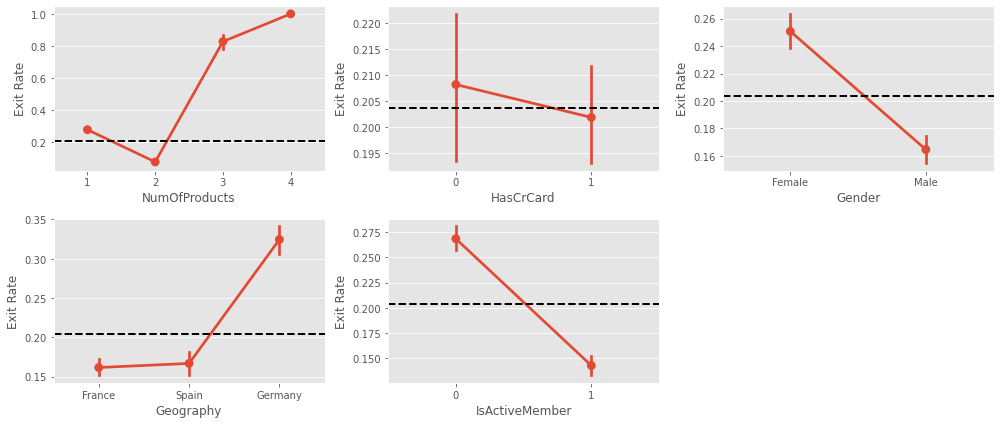

In [7]:
# prepare a figure that contains subplots for each categorical feature
fig, axes = plt.subplots(2, 3, figsize=(14, 6), sharey=False)

ref_line = data.Exited.mean()

for idx,feature in enumerate(['NumOfProducts','HasCrCard','Gender','Geography','IsActiveMember']):
    
    ax = axes.flatten()[idx]
    
    # plot the data
    sns.pointplot(x=feature, y='Exited', data=data, ax=ax);
    ax.axhline(y=ref_line, color='k', linestyle='--', linewidth=2);
    ax.set_ylabel('Exit Rate')
    
axes[1,2].set_axis_off()
    
plt.tight_layout()

The churn rate across the different levels of **Geography**, **Gender**, **IsActiveMember**, and **NumOfProducts** depart significantly from the average churn rate of 0.20. Hence these features have a strong relationship to churn. **HasCrCard** does not depart appreciably from the average churn rate and therefore provides little information in that regard. This feature will not be used in our model.

Another interesting area we can explore is the interaction between two factors and their combined effect on the exit rate. Interaction occurs whenever the effects of one factor on the exit rate are not consistent for all levels of the second factor.

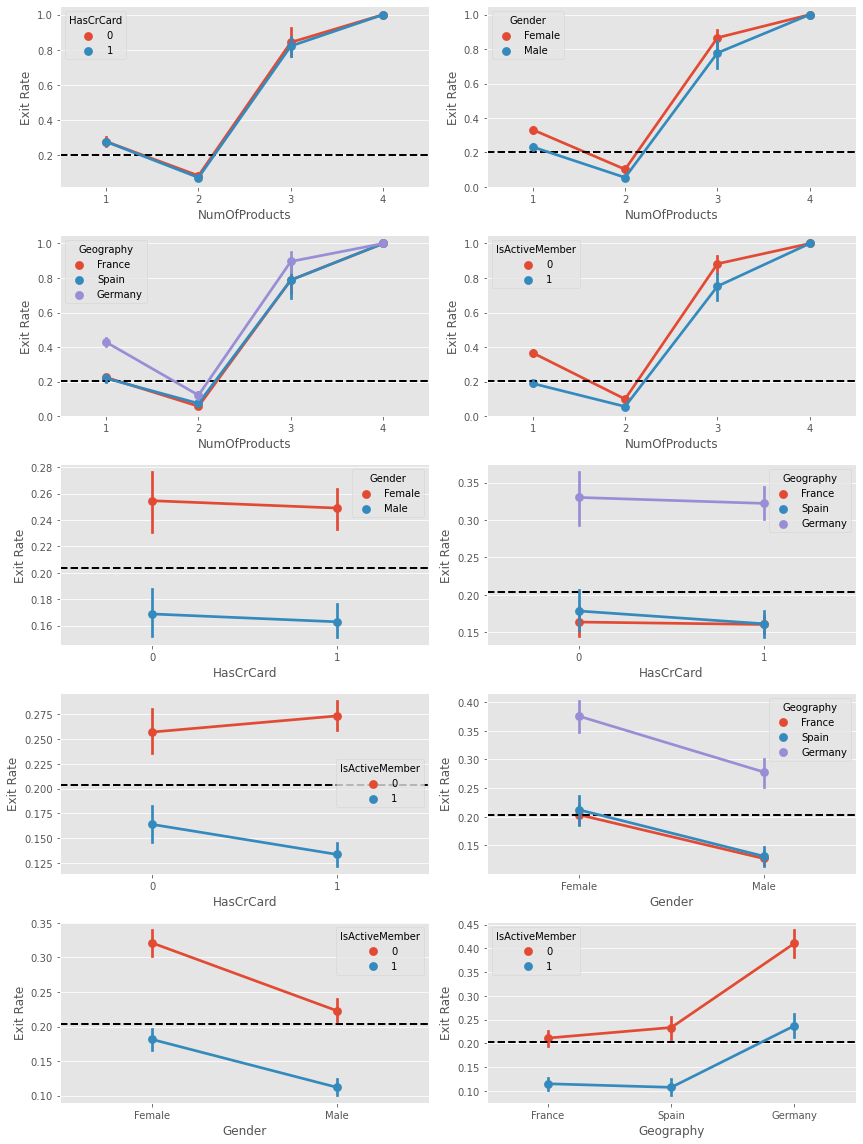

In [8]:
from itertools import combinations

# prepare a figure that contains subplots for each categorical feature
fig, axes = plt.subplots(5, 2, figsize=(12, 16))

# create reference line
ref_line = data.Exited.mean()

# create interaction combinations between pairs of features
interactions = combinations(['NumOfProducts','HasCrCard','Gender','Geography','IsActiveMember'],2)

for idx,features in enumerate(interactions):
    
    ax = axes.flatten()[idx]
    
    # plot the data
    ax.axhline(y=ref_line, color='k', linestyle='--', linewidth=2);
    sns.pointplot(x=features[0], y='Exited', hue=features[1], data=data, ax=ax);
    ax.set_ylabel('Exit Rate')
    
plt.tight_layout()

There appears to be some interaction between **HasCrCard** and **IsActiveMember** as suggested by the diverging lines. There is little to no interaction between the other pairs of categorical variables.

#### 2.2 Visualizing a Continuous Feature with a Categorical Response
In this section we will investigate the relationship between the exit rate and the continuous features in the dataset. Again one of the most effective ways of visualizing these relationships is through small multiples, but rather than using factor plots we will utilize box plots instead. If a relationship exists then we should observe a noticable difference in the central tendency and variation of the continuous feature across the different levels of the response. 

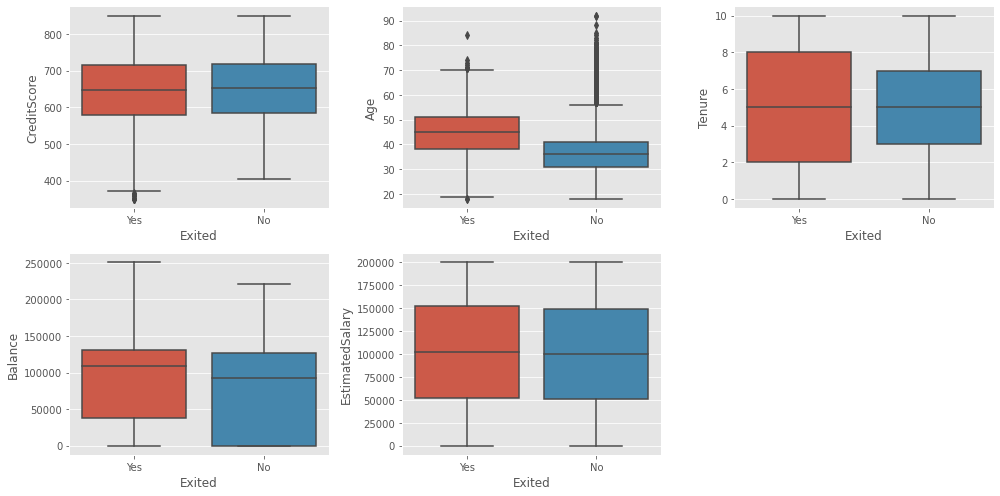

In [9]:
fig, axes = plt.subplots(2, 3, figsize=(14, 7))

for idx,feature in enumerate(['CreditScore','Age','Tenure','Balance','EstimatedSalary']):
    sns.boxplot(x=data['Exited'].map({0: 'No', 1: 'Yes'}),
                y=feature, 
                data=data, 
#                 hue='IsActiveMember',
                ax=axes.flatten()[idx], 
                linewidth=1.5);
    
axes[1,2].set_axis_off()
plt.tight_layout()

There is evidence for a relationship between **Age** and the response. Note the difference between median age for customers who exited and those that did not. There is some overlap bewtween the two groups but we can still see the seperation. There is a slight shift in the **Balance** distributions between the two groups but the overlap is very large implying that **Balance** is a weak predictor. The distributions of the remaining features are practically identically and will not be useful in predicting when a customer will exit. These features will be removed from the data set.

In [10]:
# dropping uninformative continuous features
data.drop(columns=['CreditScore','Tenure','EstimatedSalary'], inplace=True)

#### 2.2.1 Age and NumOfProducts

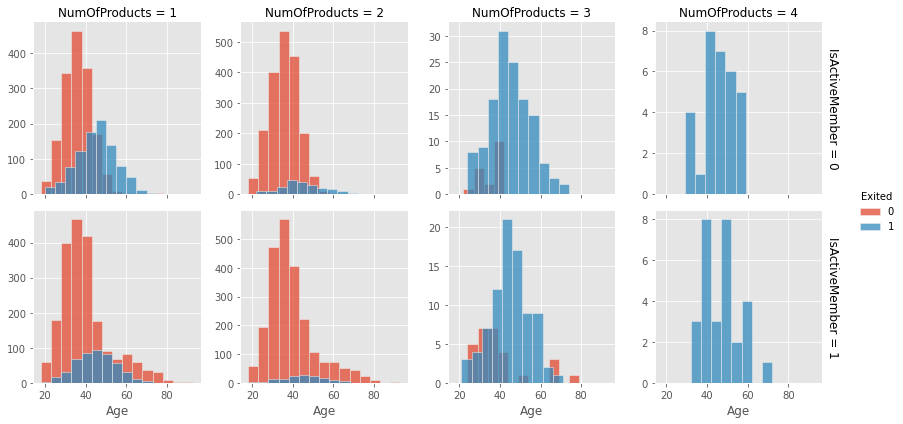

In [11]:
h = sns.FacetGrid(data, 
                  col = 'NumOfProducts', 
                  row = 'IsActiveMember', 
                  hue = 'Exited', 
                  margin_titles=True, 
                  sharey=False)
h.map(sns.histplot, 'Age', binwidth=5);
h.add_legend();

We see a high risk of churn when the number of products is anything other than two.  Furthermore, customers between the age of 40 and 50 are the ones who exit most fequently. Whether a customer is an active member or not has little influence over this fact. 

**Insights**:
- There are product offerings that lack quality, provide little to no value to the customer, or are poorly supported from a customer service perspective. I recommend gathering data on product type and taking product customer surveys. This will provide valuable information on how to correct this shortcoming.

<a id="3"></a>
### Section 3: Data Preprocessing

In this section we will first remove the features that were shown to be uniformative in the above bivariate analysis. Then we partition the data into training and tests sets using a 70:30 split. After that we transform the categorical variables using one-hot encoding, and finally we normalize our numerical features.

In [12]:
# create input feature array using only the informative features
X = data[['NumOfProducts','Gender','Geography','IsActiveMember','Age']]

# create prediction labels
y = data.Exited

# 70:30 test train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1)

In [13]:
cat_cols = X.columns[X.dtypes == 'O']
num_cols = X.columns[(X.dtypes == 'float64') | (X.dtypes == 'int64') ]

categories = [
    X[column].unique() for column in X[cat_cols]]

# create categorical transform using onehot encoding
cat_transformer = make_pipeline(OneHotEncoder(categories=categories, drop='first'))

# create numerical transformer using min-max scaler
num_transformer = make_pipeline(MinMaxScaler()) 

# create preprocessing pipeline 
preprocessor = make_column_transformer(
    (cat_transformer, cat_cols),
    (num_transformer, num_cols),
    remainder='passthrough')

In [14]:
# transform training set
X_train_trans = preprocessor.fit_transform(X_train)

# transform test set
X_test_trans = preprocessor.transform(X_test)

<a id="4"></a>
### Section 4: Build a Feedforward ANN using Keras

We start this section by building a single layer NN using a sigmoid activation function as a baseline model and then measure its performance using accuracy, precision, and recall. After this we will look to improve upon the baseline model by adding additional layers.

#### 4.1 Baseline Model

In [15]:
tf.random.set_seed(1)
tf.keras.backend.clear_session()

m_inputs = X_train_trans.shape[1]

# initialize a forward feed model
base_model = Sequential()

# add a single output layer using sigmoid activation
base_model.add(
    Dense(1, 
          input_shape = (m_inputs,), 
          activation = 'sigmoid')
)

base_model.compile(
    optimizer = optimizers.Adam(lr = 0.001),
              loss = 'binary_crossentropy', 
              metrics=['accuracy','Recall','Precision'])

base_model_hist = base_model.fit(
    X_train_trans, 
    y_train, 
    validation_split=0.1, 
    batch_size = 100, 
    epochs = 200, 
    verbose = 0)

base_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 7         
Total params: 7
Trainable params: 7
Non-trainable params: 0
_________________________________________________________________


#### 4.1.1 Baseline Results

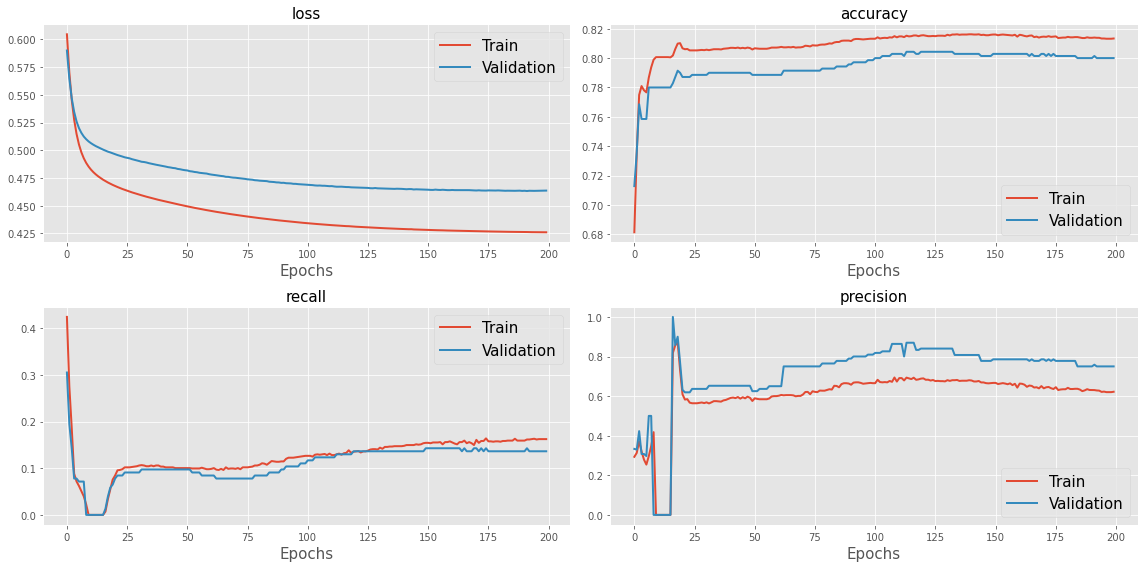

In [16]:
train_hist = list(base_model_hist.history.keys())[:4]
val_hist = list(base_model_hist.history.keys())[4:]

fig = plt.figure(figsize=(16, 8))

for idx, (train, val) in enumerate(zip(train_hist,val_hist)):
    
    ax = fig.add_subplot(2, 2, idx+1)
    plt.plot(base_model_hist.history[train], lw=2)
    plt.plot(base_model_hist.history[val], lw=2)
    plt.legend(['Train', 'Validation'], fontsize=15)
    ax.set_xlabel('Epochs', size=15);
    ax.set_title(train,size=15);


plt.tight_layout()

The baseline model is performing reasonably well. The loss is monotonically decreasing for both the training and validation sets. Below we make predicitons on the test set using 0.5 as the desicion threshold.

In [17]:
# get predicted class probabilities
y_probs = base_model.predict(X_test_trans)

# make class predictions using 0.5 decision threshold
y_pred_base = (y_probs > 0.5).astype(int)

# assemble classification report
print(classification_report(y_test,y_pred_base))

              precision    recall  f1-score   support

           0       0.82      0.98      0.89      2373
           1       0.67      0.18      0.28       627

    accuracy                           0.81      3000
   macro avg       0.74      0.58      0.59      3000
weighted avg       0.79      0.81      0.76      3000



These scores are good starting point. Next we try and improve upon them by adding more hidden layers.

#### 4.2 Feedforward ANN Model

In this section we train an ANN with **two hidden layers** and monitor the model during training. After training is complete we report the model's performance on the test set.

In [30]:
tf.keras.backend.clear_session()

n_inputs = X_train_trans.shape[1]

# initialize model
model = tf.keras.Sequential()

# add hidden layer with 12 neurons and Relu activation
model.add(Dense(units=12, input_shape=(n_inputs,), activation='relu'))
                
# add a second hidden layer with 6 neurons and Relu activation
model.add(Dense(units=6, activation='relu'))
       
# add output layer using sigmoid activation
model.add(Dense(units=1, activation='sigmoid'))

model.summary()

# compile the model
model.compile(optimizer = optimizers.Adam(lr = 0.001), 
              loss = 'binary_crossentropy', 
              metrics=['accuracy','Recall','Precision'])

# train the model
hist = model.fit(
    X_train_trans, 
    y_train, 
    validation_split=0.1, 
    batch_size = 10,
    epochs = 200, 
    verbose = 0)

# save training history 
history = hist.history

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12)                84        
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 78        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 7         
Total params: 169
Trainable params: 169
Non-trainable params: 0
_________________________________________________________________


In the next section we plot the training history and look for signs that our model is overfitting and then report on the model's performance

<a id="5"></a>
### Section 5: Model Performance

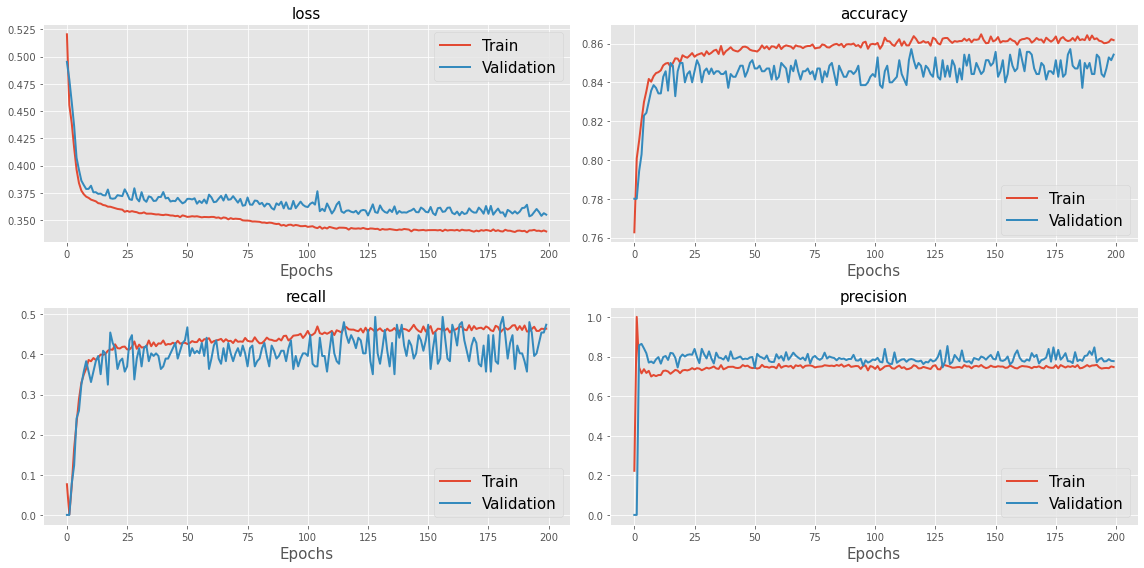

In [31]:
fig = plt.figure(figsize=(16, 8));

# training history
train_hist = list(hist.history.keys())[:4]

# validation history
val_hist = list(hist.history.keys())[4:]

for idx, (train, val) in enumerate(zip(train_hist,val_hist)):
    
    ax = fig.add_subplot(2, 2, idx+1)
    plt.plot(hist.history[train], lw=2)
    plt.plot(hist.history[val], lw=2)
    plt.legend(['Train', 'Validation'], fontsize=15)
    ax.set_xlabel('Epochs', size=15);
    ax.set_title(train,size=15);

plt.tight_layout()


The observed loss across the epochs is in general decreasing on both the training and validation sets, suggesting that our model is not overfitting. Now we make our predictions on the test set using 0.5 as the decision threshold.

In [32]:
# get predicted class probabilities
y_test_probs = model.predict(X_test_trans)

# make class predictions using 0.5 decision threshold
y_test_pred = (y_test_probs > 0.5).astype(int)

Using these predictions we assemble a confusion matrix and a classification report.

              precision    recall  f1-score   support

           0       0.88      0.96      0.92      2373
           1       0.75      0.49      0.59       627

    accuracy                           0.86      3000
   macro avg       0.81      0.72      0.75      3000
weighted avg       0.85      0.86      0.85      3000



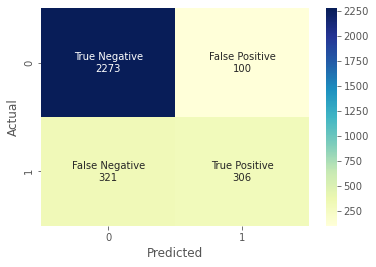

In [33]:
# create confusion matrix using the test set
confmat = confusion_matrix(y_test,y_test_pred)


names = ['True Negative','False Positive','False Negative','True Positive']
counts = ['{0:0.0f}'.format(value) for value in confmat.flatten()] # get counts from the confusion matrix
labels = [f'{v1}\n{v2}' for v1, v2 in zip(names,counts)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(confmat, annot=labels, fmt='', cmap="YlGnBu")
plt.xlabel("Predicted");
plt.ylabel("Actual");

# assemble classification report
print(classification_report(y_test,y_test_pred))

Adding two hidden layers has definitely increased the predictive power of the model. We observe an increase to all three metrics of precision, recall, and accuracy. Recall, or the true positive rate, is a measure of our model's capacity for detecting the positive case which in this study is a customer who left the bank. This event is extremely costly for the bank and we should look to improve the recall of our model. Any additional false positives that will occur are easily outweighed by the retention of customers who would have churned had the model not identified them.